# Linking Languages

To create the graph between countries, one of the parameters which could link countries is the language. One could then decide to have a binary parameter : different or same language. However, many languages share a phylogeny, a same root and are more or less linked. Dutch and German for example share a similarity which French and German don't. That is why we wanted to define a distance between the different languages. As this did not exist is any opensource database we decided to create one ourselves from the genealogic tree of the different languages which can be found here http://glottolog.org/glottolog/family. Using the different trees for all high level families, we were able to load them using the Phyloxml library in biopython. From that we exported the tree as a graph in networkx and were then able to compute the shortest path between all languages of one family. This was done iterably through all the major families all the while filling out a dataframe of distances between the different languages. 

In [15]:
import pandas as pd
import json
from matplotlib import pyplot as plt
import networkx as nx
from scipy import spatial
import numpy as np
from Bio import Phylo
import re
import os
from tqdm import tqdm
import nltk
from nltk.metrics import edit_distance

%matplotlib inline

# 1. Computing the distance between languages

In [27]:
# Function to get the list of all official languages
def get_all_languages(df):
    languages = list()

    for lang in df.languages.tolist():
        languages.append(lang)

    languages = sum(languages, [])
    languages = list(set(languages))
    return languages

# Function to get the name which corresponds the closest to the input languages
def find_closest_lang(lang, lang_list):
    
    dist = [edit_distance(lang,x) for x in lang_list]
    return lang_list[dist.index(min(dist))]
        
# Function used to match the list of languages
def match_languages(filename, country_languages,languages, simp_languages, do_prints = False):
    match = dict()
    idx_match = dict()
    bad_match = dict()
    no_match = list()

    for lang in country_languages:
        
        match1 = [x for x in simp_languages if lang == x]
        if not len(match1):
            match1 = [x for x in simp_languages if lang+"ic" == x]
        if not len(match1):
            match1 = [x for x in simp_languages if lang+"n" == x]

        match2 = [x for x in simp_languages if lang in x]
        if len(match1):
            match.update({lang: [simp_languages.index(match1[0]), match1[0], languages[simp_languages.index(match1[0])], lang]})
        #elif not len(match1) and len(match2):
            #if len(match2) == 1:
            #    match.update({lang: [simp_languages.index(match2[0]), match2[0], languages[simp_languages.index(match2[0])], lang]})
            
            #elif len(match2)>1 :
            #    closest_lang = find_closest_lang(lang, match2)
            #    match.update({lang: [simp_languages.index(closest_lang), closest_lang, languages[simp_languages.index(closest_lang)], lang]})
            #else:
            #    bad_match.update({lang: match2})
        else:
            no_match.append(lang)

    if do_prints : 
        print("Bad match ({}): ".format(len(bad_match)), bad_match)
        print()
        print("No match at all ({}): ".format(len(no_match)), no_match)
    
    return match, bad_match, no_match


# Load the phylogeny trees and return the graph and list of languages
def load_tree(filename, country_languages, vis_adj = False):
    tree = Phylo.read(filename, 'newick')
    # convert the tree to a networkx graph
    net = Phylo.to_networkx(tree)
    
    # Visualize the adjacency matrix if desired
    if vis_adj:
        A = nx.adjacency_matrix(net)
        plt.spy(A.todense(),  markersize=1)
        plt.show()
        
    # Get the different languages from the network nodes
    languages = [[x, x.name] for x in net.nodes()]
    # Remove the language codes 
    simp_languages =  [re.sub(r'\[.*$', '', x[1]) for x in languages]
    simp_languages =  [re.sub(r'\{.*$', '', x) for x in simp_languages]
    simp_languages = [re.sub(r' +$', "", x) for x in simp_languages]
    
    return net, languages, simp_languages

# Function used to compute the distances between languages
def compute_language_dist(country_languages, phylogeny_files, lang_dist):
    do_prints = False
    all_bad_match = dict()
    all_no_match = dict()
    
    for file in tqdm(phylogeny_files):
        net, languages, simp_languages = load_tree(file, country_languages)
        
        # Match the languages from the 
        match, bad_match, no_match = match_languages(file, country_languages,languages, simp_languages)
        
        if len(bad_match):
            for elem in zip(bad_match.keys(), bad_match.values()):
                print(elem[0], elem[1])
                print()
            if do_prints : print(bad_match)
        # all_bad_match.update(bad_match)
        # all_no_match.update(no_match)
        
        p=nx.shortest_path_length(net)

        for idx1 in list(match.values()):
            for idx2 in list(match.values()):
                if idx1[3] == "French":
                    print(file, idx1[3], idx2[3])
                lang_dist.loc[idx1[3], idx2[3]] = p[idx1[2][0]][idx2[2][0]]
    if do_prints : print(len(country_languages), len(match))

    return lang_dist, all_bad_match, all_no_match


In [34]:
# Loading the dataframe containing all official languages
data = pd.read_pickle(r'../DataEnriching/data.pickle')
country_languages = get_all_languages(data)

# Manually adjusting the names of certain languages
modif_dict = dict()
modif_dict.update({'Belizean Creole':"Belize Kriol English"})
modif_dict.update({'Māori':"Maori"})
modif_dict.update({'Tongan':"Rarotongan"})
modif_dict.update({'Kirundi':"Rundi"})
modif_dict.update({'Tshiluba':"Luba-Lulua"})
modif_dict.update({'Jamaican Patois':"Jamaican Creole English"})
modif_dict.update({'Hassaniya':'Hassaniyya'})
modif_dict.update({'Slovene':'Slovenian'})
modif_dict.update({'Khoisan':'Afrikaans'})
modif_dict.update({'Chibarwe':'Zimbabwean Ndebele'})
modif_dict.update({'Swazi':'Swati'})
modif_dict.update({'Sorani':'Central Kurdish'})
modif_dict.update({'Northern Ndebele':'Zimbabwean Ndebele'})
modif_dict.update({'Maldivian':'Dhivehi'})
modif_dict.update({'Zimbabwean Sign Language':'Zimbabwe Sign Language'})
modif_dict.update({'Montenegrin':'Karashevski'})
modif_dict.update({'Mauritian Creole':'Morisyen'})
modif_dict.update({'Seychellois Creole':'Seselwa Creole French'})
modif_dict.update({'Kyrgyz':'Kirghiz'})
modif_dict.update({'Norfuk':'Pitcairn-Norfolk'})
modif_dict.update({'Jèrriais':'Jerriais'})
modif_dict.update({'Guernésiais':'Dgernesiais'})
modif_dict.update({'Cook Islands Māori':'Rarotongan'})
modif_dict.update({'Greenlandic':'Kalaallisut'})
modif_dict.update({'Chinese':'Mandarin Chinese'})
modif_dict.update({'Azerbaijani':'North Azerbaijani'})
modif_dict.update({'Sami':'Akkala Sami'})
modif_dict.update({'Persian':'Western Farsi'})
modif_dict.update({'Comorian':'Maore Comorian'})
modif_dict.update({'Guaraní':'Tupi-Guarani'})
modif_dict.update({'Tokelauan':'Tokelau'})
modif_dict.update({'Southern Ndebele':'Sumayela Ndebele'})
modif_dict.update({'Haitian Creole':'Plateau Haitian Creole'})
#modif_dict.update({'':''})
#modif_dict.update({'':''})
#modif_dict.update({'':''})

#'Malagasy', 'Lao',  'Tuvaluan'

for idx in range(len(country_languages)):
    #print(val[idx])
    if country_languages[idx] in list(modif_dict.keys()):   
        country_languages[idx] = modif_dict[country_languages[idx]]  
            
country_languages = list(set(country_languages))

# Creating the language distance dataframe
lang_dist = pd.DataFrame(columns = country_languages, index = country_languages)

for lang in country_languages:
    lang_dist[lang] = np.inf

# Loading all the phylogeny files
phylogeny_files = os.listdir(os.path.join(os.getcwd(),"PhylogenyFiles"))
phylogeny_files = [os.path.join(os.getcwd(),"PhylogenyFiles",x) for x in phylogeny_files if "newick" in x]

print("There are {} high level families".format(len(phylogeny_files)))

There are 177 high level families


Computing distance between languages based on the phylogenetical trees

In [35]:
lang_dist, bad_match, no_match = compute_language_dist(country_languages, phylogeny_files, lang_dist)

lang_dist.loc['Austro-Bavarian German', :] = lang_dist.loc['German', :]+1
lang_dist.loc['Austro-Bavarian German', 'Austro-Bavarian German'] = 0

#lang_dist.loc['Austro-Bavarian German', :] = lang_dist.loc['German', :]+1
#lang_dist.loc['Austro-Bavarian German', 'Austro-Bavarian German'] = 0


 29%|██▉       | 51/177 [00:49<02:02,  1.03it/s]

/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Bengali
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Papiamento
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Norwegian
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Spanish
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Dari
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Tok Pisin
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Fij

100%|██████████| 177/177 [01:02<00:00,  2.83it/s]

 French Faroese
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Macedonian
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Hindi
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Dhivehi
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Slovak
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Italian
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt French Manx
/Users/laila/Desktop/MT/MA3/Applied Data Analysis/ADA2017_Homeworks/Project/LinkingLanguages/PhylogenyFiles/indo1319.newick.txt F

Determining elements which have not yet been assigned. 

In [36]:
df = lang_dist.describe().transpose()
unassigned = df.loc[df["min"] == np.inf].index.tolist()
print(len(unassigned))
print(unassigned)

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/numpy/lib/function_base.py:4392: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


7
['Basque', 'Zimbabwe Sign Language', 'Malagasy', 'Hiri Motu', 'Tuvaluan', 'Korean', 'New Zealand Sign Language']


In [37]:
lang_dist.head(20)

,Mongolian,Bengali,Uzbek,Papiamento,Rundi,Norwegian,Zulu,Fijian,Kazakh,Ndau,...,New Zealand Sign Language,Dutch,Polish,Romanian,Maori,Gilbertese,Khoekhoe,Croatian,Thai,Zimbabwean Ndebele
Mongolian,0.000000,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Bengali,inf,0.000000,inf,21.000000,inf,12.000000,inf,inf,inf,inf,...,inf,16.000000,12.000000,15.000000,inf,inf,inf,13.000000,inf,inf
Uzbek,inf,inf,0.000000,inf,inf,inf,inf,inf,5.000000,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Papiamento,inf,21.000000,inf,0.000000,inf,19.000000,inf,inf,inf,inf,...,inf,23.000000,19.000000,12.000000,inf,inf,inf,20.000000,inf,inf
Rundi,inf,inf,inf,inf,0.000000,inf,12.000000,inf,inf,9.000000,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,11.000000
Norwegian,inf,12.000000,inf,19.000000,inf,0.000000,inf,inf,inf,inf,...,inf,10.000000,10.000000,13.000000,inf,inf,inf,11.000000,inf,inf
Zulu,inf,inf,inf,inf,12.000000,inf,0.000000,inf,inf,9.000000,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,3.000000
Fijian,inf,inf,inf,inf,inf,inf,inf,0.000000,inf,inf,...,inf,inf,inf,inf,10.000000,8.000000,inf,inf,inf,inf
Kazakh,inf,inf,5.000000,inf,inf,inf,inf,inf,0.000000,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Ndau,inf,inf,inf,inf,9.000000,inf,9.000000,inf,inf,0.000000,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,8.000000


In [38]:
lang_dist.to_pickle('dist_languages.pkl')

In [39]:
lang_dist = pd.read_pickle('dist_languages.pkl')


In [40]:
country_languages

['Mongolian',
 'Bengali',
 'Uzbek',
 'Papiamento',
 'Rundi',
 'Norwegian',
 'Zulu',
 'Fijian',
 'Kazakh',
 'Ndau',
 'Xhosa',
 'Spanish',
 'Dzongkha',
 'Kalaallisut',
 'Sotho',
 'Dari',
 'Tok Pisin',
 'Fiji Hindi',
 'Morisyen',
 'Norwegian Nynorsk',
 'Nepali',
 'Romansh',
 'Norwegian Bokmål',
 'Aramaic',
 'Pashto',
 'Tajik',
 'Latin',
 'Maltese',
 'Kirghiz',
 'Herero',
 'Armenian',
 'Sumayela Ndebele',
 'Jerriais',
 'Tonga',
 'Austro-Bavarian German',
 'Berber',
 'Indonesian',
 'Sinhala',
 'Russian',
 'Palauan',
 'Irish',
 'Maore Comorian',
 'Quechua',
 'Tigrinya',
 'Basque',
 'Swiss German',
 'Rarotongan',
 'Burmese',
 'Galician',
 'Bulgarian',
 'Catalan',
 'English',
 'Finnish',
 'Japanese',
 'Venda',
 'Ndonga',
 'Plateau Haitian Creole',
 'Sardinian',
 'Hassaniyya',
 'Zimbabwe Sign Language',
 'Carolinian',
 'Belarusian',
 'Hungarian',
 'Belize Kriol English',
 'Western Farsi',
 'Seselwa Creole French',
 'Aymara',
 'Tetum',
 'Chewa',
 'Swedish',
 'North Azerbaijani',
 'Bosnian',
 'Fr

In [41]:
data = pd.read_pickle(r'../DataEnriching/data.pickle')
data[("languages")].loc["Sweden"]

['Swedish']

# 2. Computing the distance between countries from the Languages

The idea here is to take all the official languages and when two countries share one or more official languages to have a minimal distance. Otherwise, if one or more of the official languages have a non infinite distance, to compute the average of these distances and use that as the distance between the countries. If no link can be found then the distance is set to inf.

In [42]:
countries = data.ISO2.tolist()

In [43]:
official_languages = dict(zip(data.ISO2.tolist(),data.languages.tolist()))


In [44]:
for key, val in zip(official_languages.keys(), official_languages.values()):
    #print(val)
    for idx in range(len(val)):
        #print(val[idx])
        if val[idx] in list(modif_dict.keys()):   
            val[idx] = modif_dict[val[idx]]  

In [45]:
# Creating the country language distance dataframe
country_lang_dist = pd.DataFrame(columns = countries, index = countries)

for country in countries:
    # Setting the distances between countries to inf
    country_lang_dist[country] = np.inf
    # Setting the diagonal to 0
    country_lang_dist.loc[country, country] = 0

country_lang_dist.head(10)

,AW,AF,AO,AI,AX,AL,AD,AE,AR,AM,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
AW,0.000000,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AF,inf,0.000000,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AO,inf,inf,0.000000,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AI,inf,inf,inf,0.000000,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AX,inf,inf,inf,inf,0.000000,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AL,inf,inf,inf,inf,inf,0.000000,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AD,inf,inf,inf,inf,inf,inf,0.000000,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AE,inf,inf,inf,inf,inf,inf,inf,0.000000,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AR,inf,inf,inf,inf,inf,inf,inf,inf,0.000000,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
AM,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.000000,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [46]:
for country1 in countries:
    for country2 in countries:
        if country1 != country2:
            
            # Check if there is an official language in common
            lang1 = official_languages[country1]
            lang2 = official_languages[country2]
            common_lang = list(set(lang1) & set(lang2))
            
            if common_lang:
                country_lang_dist.loc[country1, country2] = 0
                country_lang_dist.loc[country2, country1] = 0
                continue
                
            # Check if there are languages with non infinite distance
            else : 
                dist_langs = list()
                for lang1_ in lang1: 
                    for lang2_ in lang2:
                        dist_langs.append(lang_dist.loc[lang1_, lang2_])
                            
                dist_langs = [ x for x in dist_langs if x != np.inf]
                if len(dist_langs):
                    country_lang_dist.loc[country1, country2] = np.mean(np.array(dist_langs))

In [47]:
country_lang_dist.to_pickle('country_dist_languages.pkl')
country_lang_dist.head(20)

,AW,AF,AO,AI,AX,AL,AD,AE,AR,AM,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
AW,0.000000,17.500000,13.500000,17.500000,16.500000,12.500000,12.500000,inf,13.500000,15.000000,...,17.500000,17.500000,inf,18.500000,18.500000,17.500000,inf,15.500000,17.500000,16.500000
AF,17.500000,0.000000,20.000000,15.000000,13.000000,7.000000,16.000000,10.000000,18.000000,9.500000,...,15.000000,15.000000,inf,17.666667,21.000000,15.000000,10.000000,14.000000,15.000000,13.000000
AO,13.500000,20.000000,0.000000,23.000000,21.000000,15.000000,6.000000,inf,6.000000,17.500000,...,23.000000,23.000000,inf,20.333333,13.000000,23.000000,inf,22.000000,23.000000,21.666667
AI,17.500000,15.000000,23.000000,0.000000,12.000000,10.000000,19.000000,inf,21.000000,12.500000,...,0.000000,0.000000,inf,0.000000,24.000000,0.000000,inf,0.000000,0.000000,0.000000
AX,16.500000,13.000000,21.000000,12.000000,0.000000,8.000000,17.000000,inf,19.000000,10.500000,...,12.000000,12.000000,inf,16.000000,22.000000,12.000000,inf,11.000000,12.000000,12.000000
AL,12.500000,7.000000,15.000000,10.000000,8.000000,0.000000,11.000000,inf,13.000000,4.500000,...,10.000000,10.000000,inf,12.666667,16.000000,10.000000,inf,9.000000,10.000000,8.666667
AD,12.500000,16.000000,6.000000,19.000000,17.000000,11.000000,0.000000,inf,4.000000,13.500000,...,19.000000,19.000000,inf,16.333333,9.000000,19.000000,inf,18.000000,19.000000,17.666667
AE,inf,10.000000,inf,inf,inf,inf,inf,0.000000,inf,inf,...,inf,inf,inf,inf,inf,inf,0.000000,inf,inf,inf
AR,13.500000,18.000000,6.000000,21.000000,19.000000,13.000000,4.000000,inf,0.000000,15.500000,...,21.000000,21.000000,inf,18.333333,11.000000,21.000000,inf,20.000000,21.000000,19.666667
AM,15.000000,9.500000,17.500000,12.500000,10.500000,4.500000,13.500000,inf,15.500000,0.000000,...,12.500000,12.500000,inf,15.166667,18.500000,12.500000,inf,11.500000,12.500000,11.166667


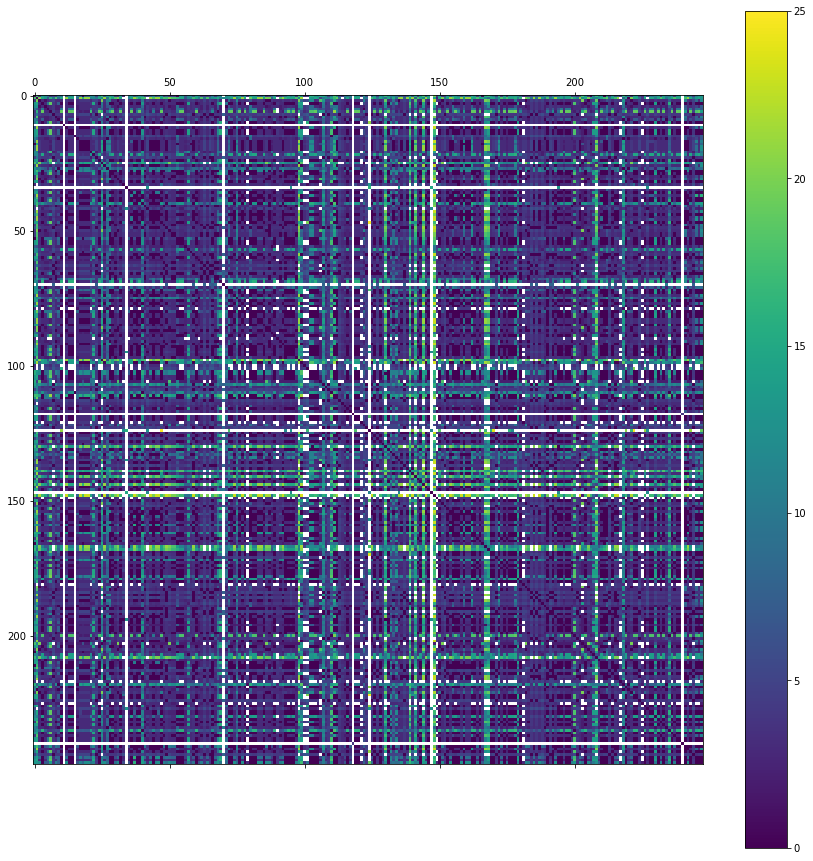

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(num = 1, figsize = (15,15))
plt.matshow(country_lang_dist, fignum = 1 )
plt.colorbar()

Khmer, Vietnamese : connected only to each other
Antartica : no language

In [3]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
stand_country_dist_languages = pd.read_pickle('./country_dist_languages.pkl')

Standardizing the distances

In [4]:
stand_country_dist_languages

std_scaler = StandardScaler().fit(stand_country_dist_languages.)
stand_country_dist_languages = std_scaler.transform(stand_country_dist_languages)

# Adding the multiindex column : 
stand_country_dist_languages.columns=pd.MultiIndex.from_tuples([('language_dist',stand_country_dist_languages.columns[i]) for i in range(len(stand_country_dist_languages))])
stand_country_dist_languages.index.name = 'ISO2'
stand_country_dist_languages.to_pickle("stand_country_dist_languages.pkl")




ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [13]:
stand_country_dist_languages

language_dist                                                         \
                AW         AF         AO         AI         AX         AL   
ISO2                                                                        
AW        0.000000  17.500000   4.000000  13.000000  12.000000   9.000000   
AF       17.500000   0.000000  20.000000  15.000000  13.000000   7.000000   
AO        4.000000  20.000000   0.000000   3.000000   1.000000   3.000000   
AI       13.000000  15.000000   3.000000   0.000000   3.000000  10.000000   
AX       12.000000  13.000000   1.000000   3.000000   0.000000   2.000000   
AL        9.000000   7.000000   3.000000  10.000000   2.000000   0.000000   
AD        4.000000  16.000000   4.000000  19.000000   3.000000   3.000000   
AE        5.000000  10.000000   5.000000   4.000000   4.000000   4.000000   
AR        4.500000  18.000000   3.000000   3.000000   2.000000   2.000000   
AM       10.250000   9.500000   3.000000   7.500000   2.000000   2.000000   
AS        9.666667  15.000000   3.000000   0.000000   3.000000  10.000000   
AQ             inf        inf        inf        inf        inf        inf   
TF        7.500000  21.000000   4.000000   3.000000   3.000000   3.000000   
AG       13.000000  15.000000   3.000000   0.000000   3.000000  10.000000   
AU       13.000000  15.000000   3.000000   0.000000   3.000000  10.000000   
AT       13.000000  13.000000   5.000000   4.000000   4.000000   4.000000   
AZ       10.500000   8.666667   3.000000   3.000000   2.000000   2.000000   
BI        7.500000  21.000000   4.000000   3.000000   3.000000   3.000000   
BE        0.000000  16.000000   4.000000   3.000000   3.000000   3.000000   
BJ        7.500000  21.000000   4.000000   3.000000   3.000000   3.000000   
BF        7.500000  21.000000   4.000000   3.000000   3.000000   3.000000   
BD       12.000000  11.000000   3.000000   4.000000   3.000000   8.000000   
BG       11.500000  12.000000   5.000000  15.000000   4.000000   4.000000   
BH        5.000000  10.000000   5.000000   4.000000   4.000000   4.000000   
BS       13.000000  15.000000   3.000000   0.000000   3.000000  10.000000   
BA       17.500000  12.000000  20.000000  10.666667   9.333333   7.000000   
BL        7.500000  21.000000   4.000000   3.000000   3.000000   3.000000   
BY       13.000000  10.000000  10.500000   8.000000   6.500000   3.500000   
BZ       13.333333  17.666667  11.333333   0.000000   7.333333   9.000000   
BM       13.000000  15.000000   3.000000   0.000000   3.000000  10.000000   
...            ...        ...        ...        ...        ...        ...   
TJ       16.000000   8.000000  13.500000  11.000000   9.500000   6.500000   
TK        9.666667  15.000000   3.000000   0.000000   3.000000  10.000000   
TM       10.500000   0.000000   3.000000   3.000000   2.000000   2.000000   
TL        4.000000  20.000000   0.000000   3.000000   1.000000   3.000000   
TO       13.000000  15.000000   3.000000   0.000000   3.000000  10.000000   
TT       13.000000  15.000000   3.000000   0.000000   3.000000  10.000000   
TN        5.000000  10.000000   5.000000   4.000000   4.000000   4.000000   
TR        3.000000   4.000000   3.000000        inf   2.000000   2.000000   
TV       13.000000  15.000000   3.000000   0.000000   3.000000  10.000000   
TW        5.000000        inf   5.000000   2.000000   4.000000   4.000000   
TZ        9.333333  15.000000   2.500000   0.000000   2.500000  10.000000   
UG        9.333333  15.000000   2.500000   0.000000   2.500000  10.000000   
UA       11.500000  11.000000   4.000000  14.000000   3.000000   3.000000   
UM       13.000000  15.000000   3.000000   0.000000   3.000000  10.000000   
UY        4.500000  18.000000   3.000000   3.000000   2.000000   2.000000   
US       13.000000  15.000000   3.000000   0.000000   3.000000  10.000000   
UZ       10.500000   9.750000   3.000000   3.000000   2.000000   2.000000   
VA        9.500000  13.000000   7.500000  16.000000   7.500000   4.500000   
V